In [102]:
#Modelos
from sklearn.linear_model import LogisticRegression  
from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder

#Medidas de validação
from sklearn.metrics import accuracy_score,recall_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from scipy.stats import uniform, randint

#Tratamento e Visualização de Dados
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Filtrar avisos desnecessários
import warnings
warnings.filterwarnings('ignore')

#Acesso aos utils
import sys
%load_ext autoreload
%autoreload 2
sys.path.append('../Utils')
from avaliacaoModelo import AvaliacaoModelo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
avalicaoModelo = AvaliacaoModelo()

In [32]:
df = pd.read_csv("../Dados/Base de dados Tratada.csv", index_col=0)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


Vamos agora preparar os nosso dados!

-Separar a base de dados em treino e teste;

-Transformar as colunas categoricas em numericas, pelas tecnicas: One-Hot Encoding(Geography e Gender) e por Mapeamento de Categorias(Card Type);

Depois disso vamos implementar nossos algoritimos de machine learning, validar os mesmos e analisar o que se saiu melhor! Como as classes estão desbalanceadas, vou ter que analisar não só a acuracia mas outras metricas como o recall, Curva ROC... Então, irei testar os modelos de machine learning com funçoes especificas para determinados modelos!

In [33]:
X = df.drop(["Exited", "Complain"], axis=1) 
y = df["Exited"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
mapeamento = {'DIAMOND': 3, 'GOLD': 2, 'SILVER': 0, 'PLATINUM': 1}
X_train["Card Type"] = X_train['Card Type'].map(mapeamento)#Transformando os valores dos cartões em valores numericos com base na sua relevancia(0 à 3)
X_test["Card Type"] = X_test['Card Type'].map(mapeamento)

In [ ]:

# Separar as colunas categóricas e numéricas
cat_cols = ['Geography']

# LabelEncode na coluna binária 'Gender' 
le_gen = LabelEncoder()
X_train['Gender'] = le_gen.fit_transform(X_train['Gender'])
X_test['Gender'] = le_gen.transform(X_test['Gender'])

# OneHotEncode nas colunas com múltiplas categorias
ohe = OneHotEncoder(drop=None, sparse_output=False)  # drop='first' para evitar multicolinearidade

# Aplicar apenas nas colunas categóricas
X_train_ohe = ohe.fit_transform(X_train[cat_cols])
X_test_ohe = ohe.transform(X_test[cat_cols])

# Converter para DataFrame e nomear colunas
ohe_cols = ohe.get_feature_names_out(cat_cols)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_cols, index=X_train.index)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_cols, index=X_test.index)

# Concatenar ohe ao restante dos dados
X_train = pd.concat([X_train.drop(cat_cols, axis=1), X_train_ohe], axis=1)
X_test = pd.concat([X_test.drop(cat_cols, axis=1), X_test_ohe], axis=1)


In [36]:
X_train

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned,Geography_France,Geography_Germany,Geography_Spain
4791,709,1,35,2,0.00,2,1,0,104982.39,2,2,422,0.0,0.0,1.0
8881,744,1,29,1,43504.42,1,1,1,119327.75,1,1,607,1.0,0.0,0.0
6166,773,1,64,2,145578.28,1,0,1,186172.85,1,0,630,1.0,0.0,0.0
4473,646,0,29,4,105957.44,1,1,0,15470.91,1,1,345,0.0,1.0,0.0
854,675,0,57,8,0.00,2,0,1,95463.29,3,0,632,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4239,636,0,39,3,118336.14,1,1,0,184691.77,3,2,349,1.0,0.0,0.0
4486,528,1,35,3,156687.10,1,1,0,199320.77,4,1,982,1.0,0.0,0.0
541,622,1,26,9,0.00,2,1,1,153237.59,3,1,344,1.0,0.0,0.0
8505,592,1,28,5,137222.77,1,0,0,39608.58,4,3,282,1.0,0.0,0.0


Após o pré-processamento adequado dos dados — incluindo a codificação de variáveis categóricas, normalização de variáveis numéricas e divisão em conjuntos de treino e teste — a próxima etapa consiste na avaliação inicial de diferentes algoritmos de classificação.

Nesta fase, os modelos são treinados com seus parâmetros padrão (default) com o objetivo de estabelecer uma linha de base (baseline) de desempenho. Essa abordagem é fundamental, pois permite:

Avaliar qual modelo se comporta melhor inicialmente, mesmo sem ajustes finos;

Servir de ponto de comparação com os modelos otimizados posteriormente (com ajuste de hiperparâmetros);

In [37]:

def predicaoModelosArvores(modelo, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


    model = modelo(random_state=42, class_weight='balanced',max_depth=10)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acuracia = accuracy_score(y_test, y_pred)
    rc = recall_score(y_test, y_pred)
    print(acuracia, rc)

predicaoModelosArvores(DecisionTreeClassifier, X_train, y_train)
predicaoModelosArvores(RandomForestClassifier, X_train, y_train)
predicaoModelosArvores(BalancedRandomForestClassifier, X_train, y_train)


0.761875 0.6441717791411042
0.835 0.6073619631901841
0.6525 0.8895705521472392


In [38]:
def predicaoModelosGBboost(modelo, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    class_counts = y_train.value_counts()
    negativos = class_counts[0]
    positivos = class_counts[1]
    scale_pos_weight = negativos/positivos #servi para o modelo dar um foco maior na classe com menor numeros de dados na target

    model = modelo(scale_pos_weight=scale_pos_weight, learning_rate=0.1, random_state=42)
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acuracia = accuracy_score(y_test, y_pred)
    rc = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(acuracia, rc, f1)

predicaoModelosGBboost(XGBClassifier,  X_train, y_train)

0.81375 0.6840490797546013 0.5994623655913979


In [40]:
def predicaoModelosLogistico(modelo, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = modelo(class_weight='balanced', max_iter=1000, solver='lbfgs')
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    acuracia = accuracy_score(y_test, y_pred)
    rc = recall_score(y_test, y_pred)
    print(acuracia, rc)

predicaoModelosLogistico(LogisticRegression,  X_train, y_train)

0.710625 0.7085889570552147




### Seleção de Modelos para Otimização

Após a avaliação inicial dos modelos com hiperparâmetros padrão (baseline), os dois algoritmos que apresentaram **melhor desempenho geral** foram o **XGBClassifier** e o **BalancedRandomForestClassifier**. Ambos se destacaram principalmente pelas métricas de **F1-score**, **recall** e **AUC-ROC**, que são fundamentais em problemas de classificação desbalanceada como o churn de clientes.

#### Próximos passos: ajuste de hiperparâmetros

Para melhorar ainda mais o desempenho desses modelos, será realizada a **otimização dos hiperparâmetros**. Esse processo visa encontrar a melhor combinação de parâmetros internos para que o modelo atinja seu máximo potencial.

#### Por que usar o `RandomizedSearchCV`?

Como a busca por hiperparâmetros envolve diversas combinações possíveis, optar pelo `GridSearchCV` seria computacionalmente inviável neste cenário, especialmente considerando o número de parâmetros e o tempo de treinamento. Por isso, será utilizado o `RandomizedSearchCV`, que realiza uma **amostragem aleatória** no espaço de busca definido, permitindo encontrar boas soluções com muito **menos custo computacional**.



In [68]:

parametrosBRFC = {
    'n_estimators': randint(50, 300),       # número de árvores
    'max_depth': randint(3, 10),            # profundidade máxima
    'min_samples_split': randint(2, 10),    # mínimo de amostras para split
    'min_samples_leaf': randint(1, 5),      # mínimo de amostras na folha
    'max_features': ['sqrt', 'log2', None]   # Ajuste para desbalanceamento
}

melhorModeloBRFC, dfModelo = avalicaoModelo.avaliacaoHiperParametros(BalancedRandomForestClassifier, parametrosBRFC, "recall", X_train, y_train)

dfModelo.head()

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
20,4.323945,0.067563,0.071180,0.005339,8,None,4,2,239,"{'max_depth': 8, 'max_features': None, 'min_sa...",0.751534,0.760736,0.791411,0.773006,0.776074,0.770552,0.013636,1
19,4.548910,0.125883,0.072790,0.005064,8,None,4,8,249,"{'max_depth': 8, 'max_features': None, 'min_sa...",0.748466,0.760736,0.794479,0.776074,0.769939,0.769939,0.015399,2
9,5.549087,0.152350,0.087803,0.007632,8,None,4,8,293,"{'max_depth': 8, 'max_features': None, 'min_sa...",0.748466,0.757669,0.791411,0.776074,0.776074,0.769939,0.015152,3
30,4.578717,0.078673,0.077112,0.004637,7,None,4,9,263,"{'max_depth': 7, 'max_features': None, 'min_sa...",0.760736,0.754601,0.782209,0.776074,0.769939,0.768712,0.010006,4
39,2.339128,0.087111,0.040736,0.003413,7,None,3,4,135,"{'max_depth': 7, 'max_features': None, 'min_sa...",0.757669,0.751534,0.779141,0.779141,0.773006,0.768098,0.011412,5


In [77]:
parametrosXGB = {
    'max_depth': randint(3, 5),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'scale_pos_weight': [3.9364102564102565],  # Ajuste para desbalanceamento
}
melhorModeloXGB, dfModelo = avalicaoModelo.avaliacaoHiperParametros(XGBClassifier, parametrosXGB, "recall", X_train, y_train)

dfModelo.head()

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_scale_pos_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.266489,0.008867,0.018826,0.002050,0.759944,0.024,4,3,3.93641,0.752985,"{'colsample_bytree': 0.7599443886861021, 'lear...",0.742331,0.739264,0.769939,0.763804,0.748466,0.752761,0.012053,1
15,0.213112,0.007189,0.017435,0.003086,0.666107,0.014691,3,8,3.93641,0.757953,"{'colsample_bytree': 0.6661067756252009, 'lear...",0.736196,0.739264,0.760736,0.751534,0.751534,0.747853,0.008975,2
3,0.275239,0.021906,0.016369,0.001432,0.975421,0.010234,4,5,3.93641,0.846993,"{'colsample_bytree': 0.9754210836063001, 'lear...",0.754601,0.711656,0.757669,0.760736,0.754601,0.747853,0.018241,2
42,0.235683,0.015743,0.014724,0.000709,0.950936,0.087382,4,9,3.93641,0.806654,"{'colsample_bytree': 0.9509357413523924, 'lear...",0.730061,0.736196,0.776074,0.745399,0.751534,0.747853,0.015927,4
29,0.278024,0.006063,0.017056,0.001026,0.944292,0.012086,4,9,3.93641,0.793932,"{'colsample_bytree': 0.9442922333025374, 'lear...",0.751534,0.717791,0.751534,0.754601,0.760736,0.747239,0.015102,5



### Validação do Modelo com Hiperparâmetros Otimizados

Após o ajuste de hiperparâmetros por meio do `RandomizedSearchCV`, agora é o momento de **validar o desempenho final dos modelos selecionados**. Essa validação é essencial para garantir que os resultados obtidos não são fruto de um acaso ou de overfitting ao conjunto de treino.

#### Análise preliminar

Já é possível observar que o **BalancedRandomForestClassifier** apresentou uma **média de *recall* superior** ao longo das avaliações, o que é um indicativo importante de bom desempenho neste contexto. Como o problema de churn envolve **identificar corretamente os clientes que irão sair**, o recall (sensibilidade) se torna uma métrica crítica, pois penaliza menos falsos positivos e valoriza os verdadeiros positivos — ou seja, **quem realmente saiu e foi corretamente identificado**.

#### Validação com Cross-Validation

Para reforçar essa conclusão, será realizada uma **validação cruzada com a métrica de *recall* e de *acurácia*** usando a função `cross_val_score`. Essa etapa permite avaliar a **estabilidade do modelo em diferentes divisões dos dados**, fornecendo uma visão mais robusta do desempenho real do algoritmo.

Essa análise final servirá como **confirmação da escolha do modelo** e como base para comparação com versões futuras, além de reforçar a confiabilidade do processo.

In [74]:
avalicaoModelo.avaliacaoCruzada(melhorModeloBRFC, X_train, y_train)

Acurácia em cada fold: Acuracia =  [0.776875 0.789375 0.788125 0.78125  0.791875]
Acurácia em cada fold: recall =  [0.75153374 0.7607362  0.79141104 0.77300613 0.77607362]
Acurácia média: 0.7855000000000001
Recall medio:  0.7705521472392638


In [78]:
avalicaoModelo.avaliacaoCruzada(melhorModeloXGB, X_train, y_train)

Acurácia em cada fold: Acuracia =  [0.7925   0.80625  0.798125 0.791875 0.795   ]
Acurácia em cada fold: recall =  [0.7392638  0.73006135 0.76380368 0.76380368 0.7607362 ]
Acurácia média: 0.79675
Recall medio:  0.7515337423312884




### ✅ Conclusão da Validação e Escolha do Modelo Final

Após a aplicação da validação cruzada com as métricas de **acurácia** e **recall**, os dois modelos ajustados — **XGBClassifier** e **BalancedRandomForestClassifier** — apresentaram desempenhos competitivos. No entanto, o **Balanced Random Forest se destacou no recall médio**, métrica central para o contexto de churn, onde é crucial **identificar corretamente os clientes que têm maior chance de sair da base**.

### Resultados comparativos:

| Modelo                   | Acurácia Média | Recall Médio |
| ------------------------ | -------------- | ------------ |
| **XGBClassifier**        | 0.7968         | 0.7515       |
| **BalancedRandomForest** | 0.7855         | **0.7706**   |

Apesar de o XGBoost ter apresentado uma acurácia ligeiramente superior, o **Balanced Random Forest obteve um recall mais alto e mais consistente entre os folds**, o que reforça sua robustez na **detecção da classe minoritária (clientes que saem)**.

---

### Modelo Final Selecionado

Com base nos critérios avaliados, o **BalancedRandomForestClassifier foi o modelo escolhido para ser utilizado em produção/análises futuras**. Sua capacidade de manter um bom desempenho em múltiplas divisões dos dados, somada ao foco na classe de maior interesse (churn), o torna a melhor opção para este projeto.



Agora vamos analisar a curva Roc e a matris de confusão!

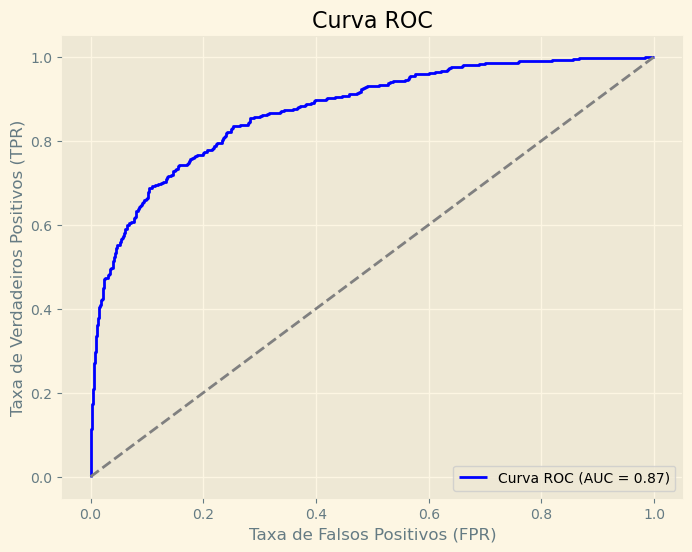

In [92]:
avalicaoModelo.curvaRoc(melhorModeloBRFC, X_test, y_test)


###  Desempenho Final – Curva ROC

O modelo final — **BalancedRandomForestClassifier**, após ajustes e validação cruzada — apresentou uma **área sob a curva ROC (AUC-ROC) de 0.87**, o que indica um **excelente poder discriminativo** entre as classes.

A curva ROC mede a capacidade do modelo em **separar corretamente as classes positiva (clientes que saem) e negativa (clientes que permanecem)** em diferentes limiares de decisão. Um valor de AUC igual a 0.5 indicaria um modelo aleatório, enquanto 1.0 representa separação perfeita.

> 🔍 **Com AUC = 0.87**, o modelo consegue distinguir corretamente clientes que sairão em aproximadamente 87% das situações — um resultado muito satisfatório para problemas de classificação desbalanceada como churn.

Esse desempenho confirma que o modelo não só possui um bom recall, como também mantém uma **alta taxa de verdadeiros negativos e positivos em equilíbrio**, sem depender de um limiar fixo.



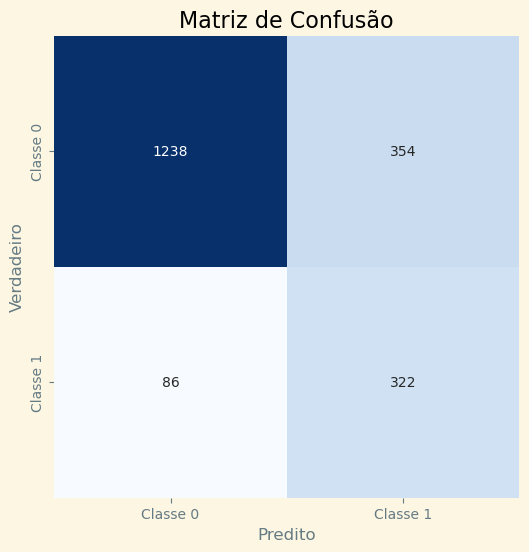

In [93]:
avalicaoModelo.matrizConfusao(melhorModeloBRFC, X_test, y_test)



### Análise da Matriz de Confusão

A matriz de confusão obtida com o modelo final é:

|                        | **Classe 0 (Verdadeira)** | **Classe 1 (Verdadeira)** |
| ---------------------- | ------------------------- | ------------------------- |
| **Classe 0 (Predita)** | 1238 (True Negatives)     | 86 (False Negatives)      |
| **Classe 1 (Predita)** | 354 (False Positives)     | 322 (True Positives)      |

###  Interpretação:

* **1238 clientes** que permaneceram foram corretamente classificados como **não churn** (Verdadeiros Negativos);
* **322 clientes** que saíram foram corretamente identificados como **churn** (Verdadeiros Positivos);
* **354 clientes** que não saíram foram classificados incorretamente como churn (Falsos Positivos);
* **86 clientes** que saíram foram classificados incorretamente como permanentes (Falsos Negativos).

###  Destaques:

* O modelo teve um **baixo número de falsos negativos (86)**, o que é crucial no contexto de churn, pois significa que ele **consegue identificar a maioria dos clientes que vão sair** — refletido no alto *recall* da classe positiva.
* Os **falsos positivos (354)** indicam que o modelo às vezes classifica erroneamente clientes fiéis como churn, o que pode ser tolerável em troca de evitar a perda de clientes realmente propensos a sair.

> 🔍 **Conclusão**: O modelo está conseguindo equilibrar bem a identificação de clientes que saem e os que permanecem, **com forte ênfase em não deixar passar churners**, o que é a prioridade nesse tipo de problema.



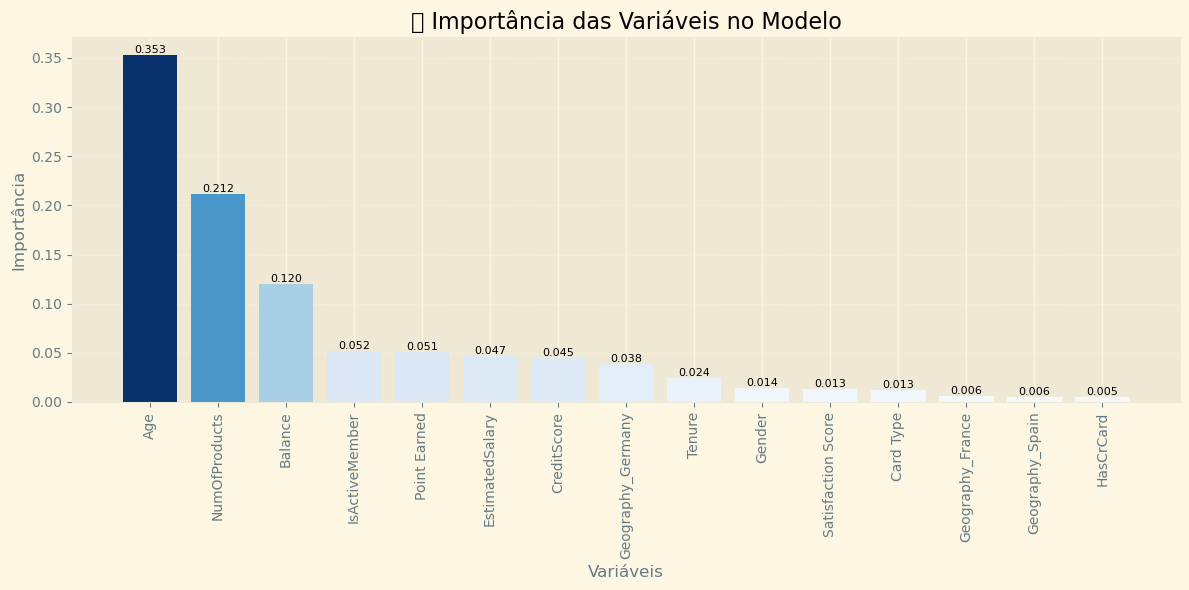

In [104]:
avalicaoModelo.importanciaVariaveis(melhorModeloBRFC, X_train)


###  Análise de Importância das Variáveis

Após o treinamento e validação do modelo final (**BalancedRandomForestClassifier**), foi possível extrair as **importâncias das variáveis** utilizadas na previsão de churn. Esses resultados indicam quais atributos mais contribuíram para a tomada de decisão do modelo.

As variáveis mais relevantes foram:

* **Idade (`Age`)** – Clientes mais velhos demonstraram maior propensão à evasão, comportamento já evidenciado na análise exploratória;
* **Número de produtos (`NumOfProducts`)** – A relação não é linear: tanto clientes com apenas **um produto** quanto aqueles com **múltiplos produtos** apresentaram maior chance de churn, sugerindo a existência de diferentes perfis de saída;
* **Saldo bancário (`Balance`)** – Saldos elevados foram recorrentes entre os clientes que saíram, especialmente na **Alemanha**, onde o perfil de churn parece concentrado em clientes mais ricos e mais velhos;
* **Atividade na conta (`IsActiveMember`)** – Clientes com menor nível de atividade apresentaram maior taxa de evasão, o que reforça a importância do engajamento contínuo.

---

###  Conclusão

Essas variáveis confirmam os **insights levantados na fase exploratória**. O modelo foi capaz de aprender padrões consistentes e úteis para a previsão de churn, o que fortalece a confiabilidade de suas recomendações.

Além disso, os resultados apontam **ações estratégicas de retenção**, como:

* Desenvolver ofertas e benefícios específicos para **clientes mais velhos**;
* Estimular o uso de **múltiplos produtos financeiros** de maneira equilibrada;
* Criar **campanhas de reengajamento** para usuários com alto saldo e baixa atividade recente.
